In [7]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# Load ImageNet class names
with open('imagenet_classes.txt') as f:
    class_names = [line.strip() for line in f.readlines()]

# Load pre-trained ResNet152 with correct API
model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Image preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

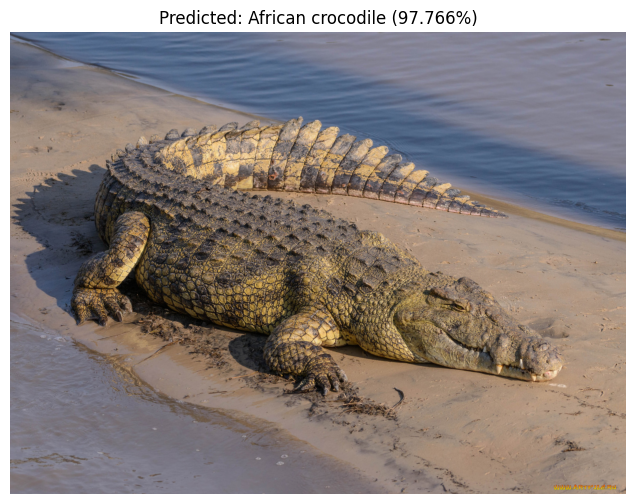

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

# Загрузите изображение для инференса
image_path = 'test_images/3.jpg'  # Замените на путь к вашему изображению
image = Image.open(image_path)
image_tensor = preprocess(image)
image_tensor = image_tensor.unsqueeze(0).to(device)  # Добавляем размер батча

# Прогоните изображение через модель
with torch.no_grad():
    output = model(image_tensor)

# Примените softmax для получения вероятностей классов
probabilities = torch.nn.functional.softmax(output[0], dim=0).cpu()

# Отображение результатов
top_prob, top_class = torch.topk(probabilities, 1)
top_prob = top_prob.item()
top_class = top_class.item()

# Получить имя класса
class_name = class_names[top_class]

# Отобразить изображение
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')
plt.title(f'Predicted: {class_name} ({top_prob*100:.3f}%)')
plt.show()

---

Добавим софтмакс прямо в архтектуру

In [3]:
import torch.nn as nn

# Load pre-trained ResNet152 with correct API
model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)

# Add Softmax layer at the end
model = nn.Sequential(
    model,  # Original ResNet152
    nn.Softmax(dim=1)  # Adds Softmax to convert outputs to probabilities
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval();

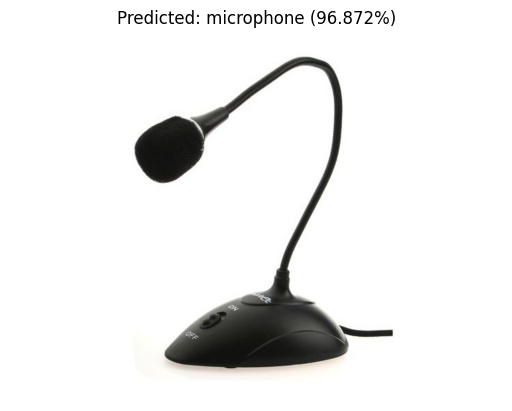

In [4]:
# Загрузите изображение для инференса
image_path = 'test_images/1.jpg'  # Замените на путь к вашему изображению
image = Image.open(image_path)
image_tensor = preprocess(image)
image_tensor = image_tensor.unsqueeze(0).to(device)  # Добавляем размер батча

# Прогоните изображение через модель
with torch.no_grad():
    output = model(image_tensor)

# Примените softmax для получения вероятностей классов
probabilities = output.cpu()

# Отображение результатов
top_prob, top_class = torch.topk(probabilities, 1)
top_prob = top_prob.item()
top_class = top_class.item()

# Получить имя класса
class_name = class_names[top_class]

# Отобразить изображение
plt.imshow(image)
plt.axis('off')
plt.title(f'Predicted: {class_name} ({top_prob*100:.3f}%)')
plt.show()

# ONNX

In [5]:
# Экспорт модели в формат ONNX
dummy_input = torch.randn(1, 3, 224, 224, device=device)  # Пример входного тензора
onnx_file_path = "model.onnx"  # Путь для сохранения ONNX файла

# Экспорт модели
with torch.no_grad():
    torch.onnx.export(
        model,  # Модель PyTorch
        dummy_input,  # Пример входных данных
        onnx_file_path,  # Путь для сохранения ONNX файла
        export_params=True,  # Экспортировать обученные параметры
        opset_version=14,  # Версия ONNX операторов
        do_constant_folding=True,  # Оптимизация констант
        input_names=["input"],  # Имя входного тензора
        output_names=["output"],  # Имя выходного тензора
        dynamic_axes={
            "input": {0: "batch_size"},  # Динамический размер батча
            "output": {0: "batch_size"},
        },
    )

print(f"Модель успешно экспортирована в файл: {onnx_file_path}")  

C:\Users\Nikita Borisov\AppData\Local\Temp\ipykernel_16704\2309754256.py:7: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Модель успешно экспортирована в файл: model.onnx
